In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Задача №2 - Собери пазл (2.0).

Даны кусочки изображения, ваша задача склеить пазл в исходную картинку. 

Условия:
* Дано исходное изображение для проверки, использовать собранное изображение в самом алгоритме нельзя;
* Картинки имеют друг с другом пересечение;
* После разрезки кусочки пазлов не были повернуты или отражены;
* НЕЛЬЗЯ выбрать опорную картинку для сбора пазла, как это было в homework 3
* В процессе проверки решения пазлы могут быть перемешаны, т.е. порядок пазлов в проверке может отличаться от исходного 

Изображения расположены по [ссылке](https://disk.yandex.ru/d/XtpawH1sV9UDlg).

Примеры изображений:
<img src="puzzle/su_fighter.jpg" alt="Drawing" style="width: 300px;"/>
<table><tr>
    <td> <img src="puzzle/su_fighter_shuffle/0.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/1.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/2.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/3.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [9]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(16, 16), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.axis('off')
    plt.show()

In [10]:
def my_spec_points(image):
    hyp_params = dict(
        nfeatures = 50,
        nOctaveLayers = 8,
        contrastThreshold = 0.005,
        edgeThreshold = 10,
        sigma = 3.0)

#     detector = cv2.xfeatures2d.SIFT_create(**hyp_params)
    detector = cv2.SIFT_create(**hyp_params)
    keypoints, desc = detector.detectAndCompute(image, None)
    
    return keypoints, desc.astype(np.float32)


In [11]:
def pos_i_piece(pos_pieces, i):
    if not(i in [l[0] for l in pos_pieces]):
        return None
    
    return pos_pieces[([l[0] for l in pos_pieces]).index(i)][1]

In [12]:
def fort_key(x):
    if len(x[1]) == 0:
        return 1000000
        
    if len(x[1]) == 1:
        return x[1][0].distance
    
    return sum(sorted([m.distance for m in x[1][:len(x)//2]])[:len(x)//2+1])/len(x)


In [25]:
def edges(pieces):
    gray_pieces = [cv2.cvtColor(piece, cv2.COLOR_RGB2GRAY) for piece in pieces]
    bottom_edge = []
    top_edge = []
    right_edge = []
    left_edge = []
    
    for i, gray_piece in enumerate(gray_pieces):
        h, w = gray_piece.shape
        if np.all(gray_piece[0, :] < 10):
            top_edge.append(i)
        if np.all(gray_piece[h-1, :] < 10):
            bottom_edge.append(i)
        if np.all(gray_piece[:, 0] < 10):
            left_edge.append(i)
        if np.all(gray_piece[:, w-1] < 10):
            right_edge.append(i)
    return bottom_edge, top_edge, right_edge, left_edge

In [40]:
def get_corner(edge1, edge2):
    return list(set(edge1) & set(edge2))[0]


In [41]:
def check_edges(dx, dy, i, bottom_edge, top_edge, right_edge, left_edge, ):
    if (i in bottom_edge) and dy > 0:
        return False
    if (i in top_edge) and dy < 0:
        return False
    if (i in right_edge) and dx > 0:
        return False
    if (i in top_edge) and dx < 0:
        return False
    return True

In [67]:
def draw_res(pieces, keypoints, good_matches, mode=0):
    bottom_edge, top_edge, right_edge, left_edge = edges(pieces)
#     print('bottom_edge', bottom_edge)
#     print('top_edge', top_edge)
#     print('right_edge', right_edge)
#     print('left_edge', left_edge)
    corn = []
    min_x = []
    min_y = []
    max_x = []
    max_y = []
    if mode == 0:
        corn = get_corner(left_edge, bottom_edge)
        min_x = 0
        max_y = 0
    elif mode == 1:
        corn = get_corner(left_edge, top_edge)
        min_x = 0
        min_y = 0
    elif mode == 2:
        corn = get_corner(right_edge, top_edge)
        max_x = 0
        min_y = 0
    elif mode == 3:
        corn = get_corner(right_edge, bottom_edge)
        max_x = 0
        max_y = 0
    
    
    
    pos_pieces = [(corn, [0, 0])]
    stack = [[corn,0, []]]
    be_done = [corn]
    
    while stack != []:  
        stack.reverse()
        stack.sort(key=lambda x: x[1])
        stack.reverse()
        
        i, num_j, temp = stack[-1]
        
#         if num_j > 2:
#             stack.pop()
#             continue
        if temp == []:
#             temp = sorted(good_matches[i], key=lambda x: len(x[1]))
            temp = sorted(good_matches[i], key=fort_key)
#             temp = sorted(good_matches[i], key=lambda x: min([m.distance for m in x[1]]))

        j = 0
        for j, gd_matches in temp[num_j:]: 
            stack[-1][1] += 1
            if pos_i_piece(pos_pieces, j) != None:
                continue
                
            if not len(gd_matches):
                continue
            
            stack.append([j, 0, []])
            
            dx = np.zeros([len(gd_matches), 1])
            dy = np.zeros([len(gd_matches), 1])
            distances = np.zeros([len(gd_matches), 1])
            for k, gd_matche in enumerate(gd_matches):
                distances[k] = gd_matche.distance
            
            
            for k, gd_matche in enumerate(gd_matches):
                x1, y1 = keypoints[i][gd_matche.queryIdx].pt
                x2, y2 = keypoints[j][gd_matche.trainIdx].pt

                dx[k] = x1 - x2
                dy[k] = y1 - y2
                

                
            w_dx = dx * (distances.max() - distances)
            w_dy = dy * (distances.max() - distances)

            av_w_dx = w_dx.mean()
            av_w_dy = w_dy.mean()

            ind_y = np.argmin(np.abs(w_dy - av_w_dy))
            ind_x = np.argmin(np.abs(w_dx - av_w_dx))

            y = int(np.round(dy[ind_y]))
            x = int(np.round(dx[ind_x]))

            if not check_edges(y, x, i, bottom_edge, top_edge, right_edge, left_edge):
                stack.pop()
                continue
            if not check_edges(-y, -x, j, bottom_edge, top_edge, right_edge, left_edge):
                stack.pop()
                continue
            
            x0, y0 = pos_i_piece(pos_pieces, i)
            x += x0
            y += y0

            if (min_x == []) and (j in left_edge):
                min_x = x
            elif (max_x == []) and (j in right_edge):
                max_x = x
            if (min_y == []) and (j in top_edge):
                min_y = y
            elif (max_y == []) and (j in bottom_edge):
                max_y = y
            
            if ((min_x != []) and x < min_x) or \
                ((max_x != []) and x > max_x) or \
                ((min_y != []) and y < min_y) or \
                ((max_y != []) and y > max_y):
                stack.pop()
                continue
                
            
            
            
            pos_pieces.append((j, [x,y]))
            break
        else:
            stack.pop()
#             print(i)
            continue
            
        
        

    x_pieces = np.array([l[1][0] for l in pos_pieces])
    y_pieces = np.array([l[1][1] for l in pos_pieces])
    min_x = x_pieces.min()
    max_x = x_pieces.max()
    min_y = y_pieces.min()
    max_y = y_pieces.max()

    sh_piece_max_x = pieces[pos_pieces[np.argmax(x_pieces)][0]].shape
    sh_piece_max_y = pieces[pos_pieces[np.argmax(y_pieces)][0]].shape
    max_x += sh_piece_max_x[1]
    max_y += sh_piece_max_y[0]


    res_im = np.zeros([max_y-min_y, max_x-min_x, 3])
    for i, pos_piece in pos_pieces:
        h, w, _ = pieces[i].shape
        x = pos_piece[0]
        y = pos_piece[1]
        res_im[y - min_y : y - min_y + h, x - min_x : x - min_x + w] = pieces[i]
    print(len(pos_pieces))
    res_im = res_im.astype(np.uint8)
    plot_one_image(res_im)
    return pos_pieces

In [68]:
def puzzle(pieces):
    ratio_thresh = 0.5
    thresh_count = 2
    
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    descs = []
    keypoints = []
    for im in pieces:
        ki, di = my_spec_points(im)
        descs.append(di)
        keypoints.append(ki)
         
    print([len(l) for l in descs])
    inds_res = []
    good_matches = []
    for i in range(len(descs)):
        good_matches.append([])
        for j in range(len(descs)):
            if i == j:
                continue
            good_matches[-1].append([j, []])
            desc1 = descs[i]
            desc2 = descs[j]
            
            matches = flann.knnMatch(desc1, desc2, k=2)
            for m, n in matches:
                if m.distance < ratio_thresh * n.distance:
                    good_matches[-1][-1][1].append(m)
                    
            if len(good_matches[-1][-1][1]) < thresh_count:
                good_matches[-1].pop()
                
    draw_res(pieces, keypoints, good_matches, 0)
    draw_res(pieces, keypoints, good_matches, 1)
    draw_res(pieces, keypoints, good_matches, 2)
    return draw_res(pieces, keypoints, good_matches, 3) 

[50, 50, 51, 50, 50, 50, 41, 50, 51, 19, 31, 50, 50, 50, 50, 39, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 31, 50, 49, 50, 51, 47, 50, 36, 50, 50, 46, 50, 36, 50, 50, 45, 50, 50, 50, 50, 50, 50, 50, 51, 50, 50, 50, 50, 50, 36, 50, 50, 51, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 27, 52, 50, 50, 50, 50, 50, 50, 50, 50, 51, 50, 50, 50, 50, 50, 50, 50, 50, 37, 50, 50, 39, 50, 50, 50, 50, 50, 50, 51, 50, 50, 50, 50, 50, 51, 50, 50, 51, 50, 19, 50, 50, 50, 50, 33, 51, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 35, 50, 50, 50, 26, 50, 50, 50, 50, 50, 50, 16, 50, 50, 50, 50, 50, 16, 51]
4


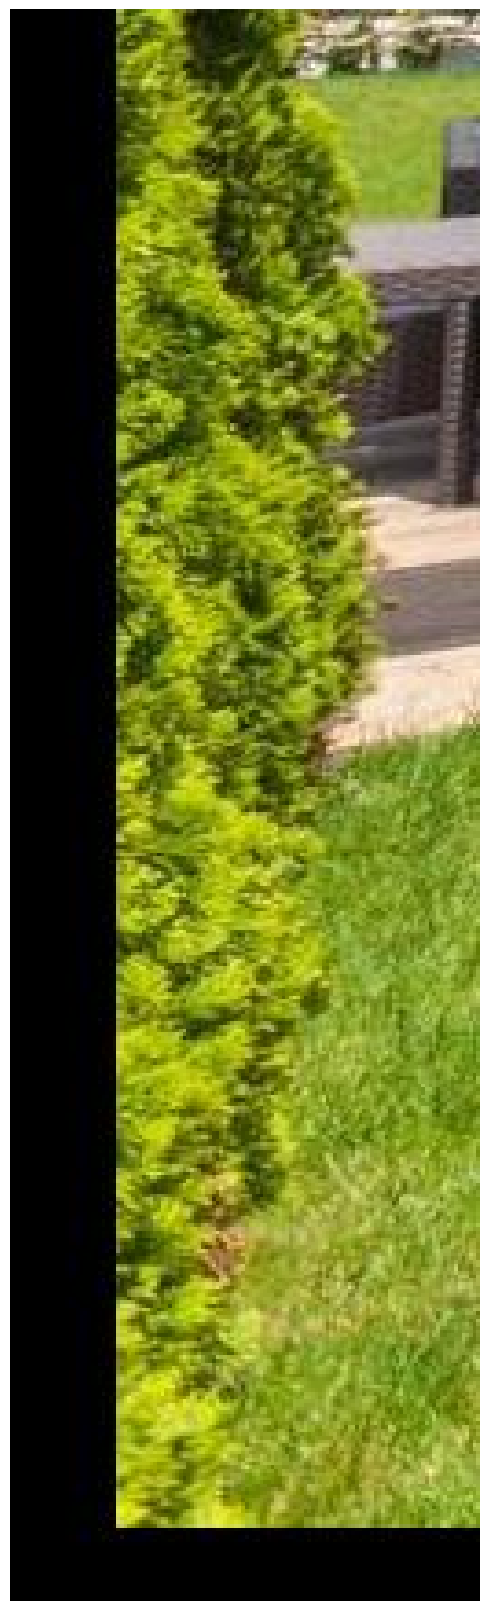

3


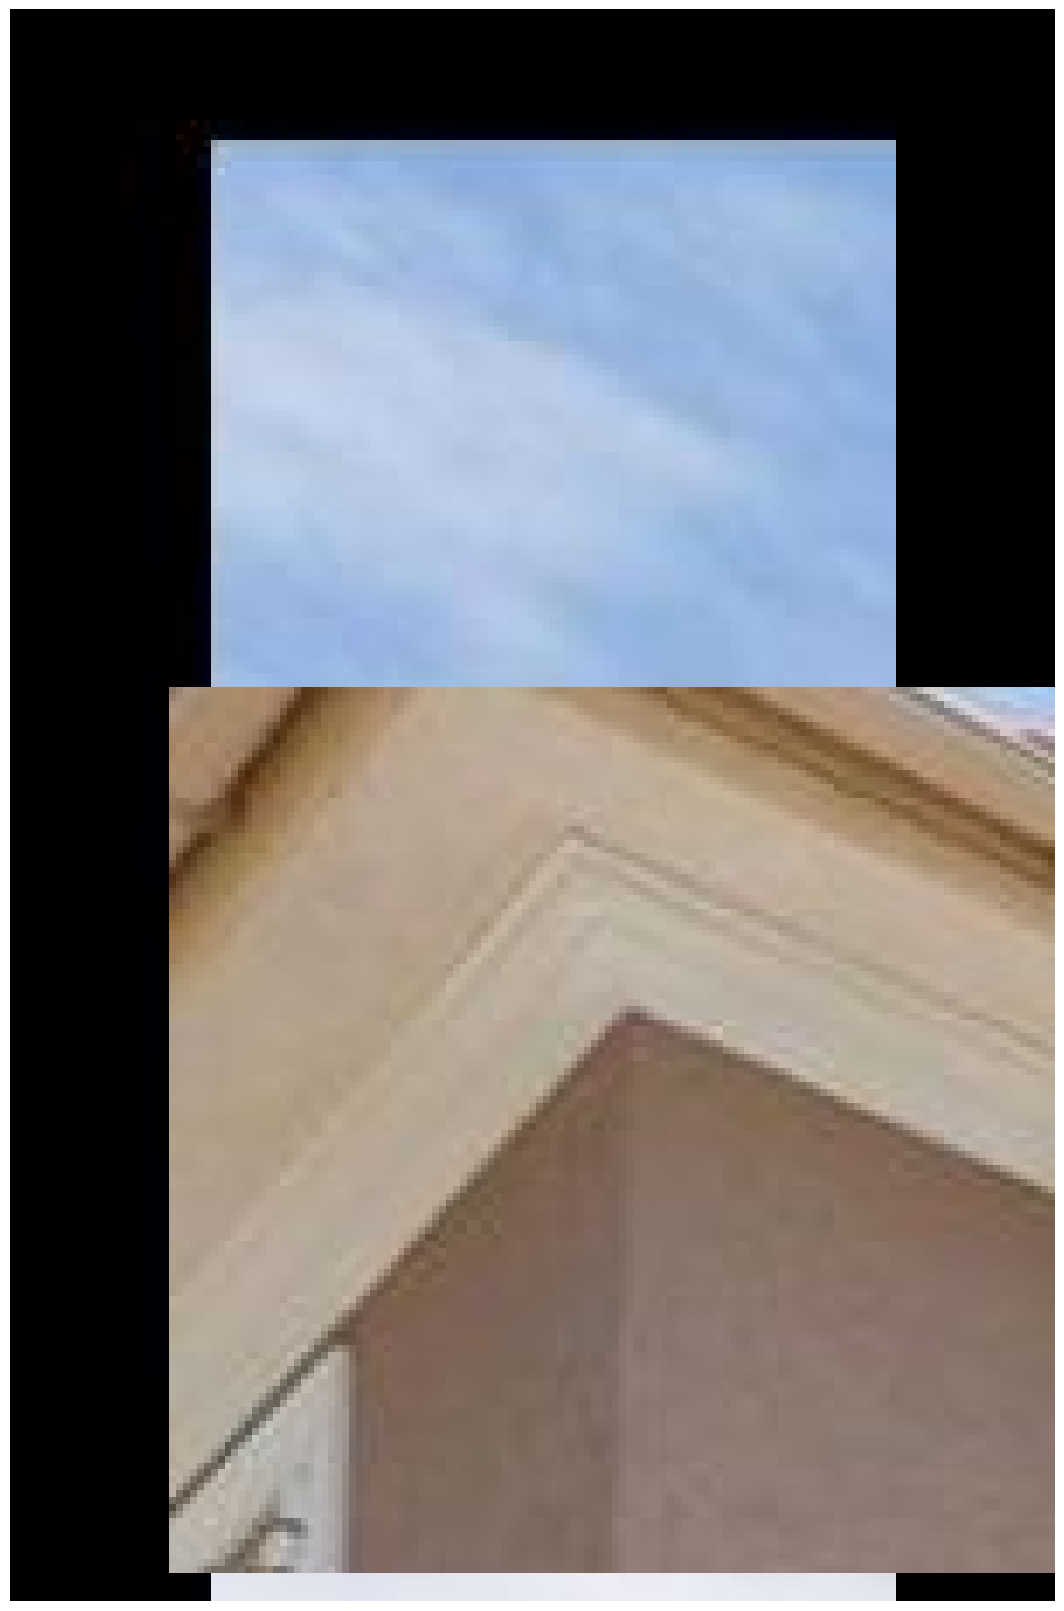

1


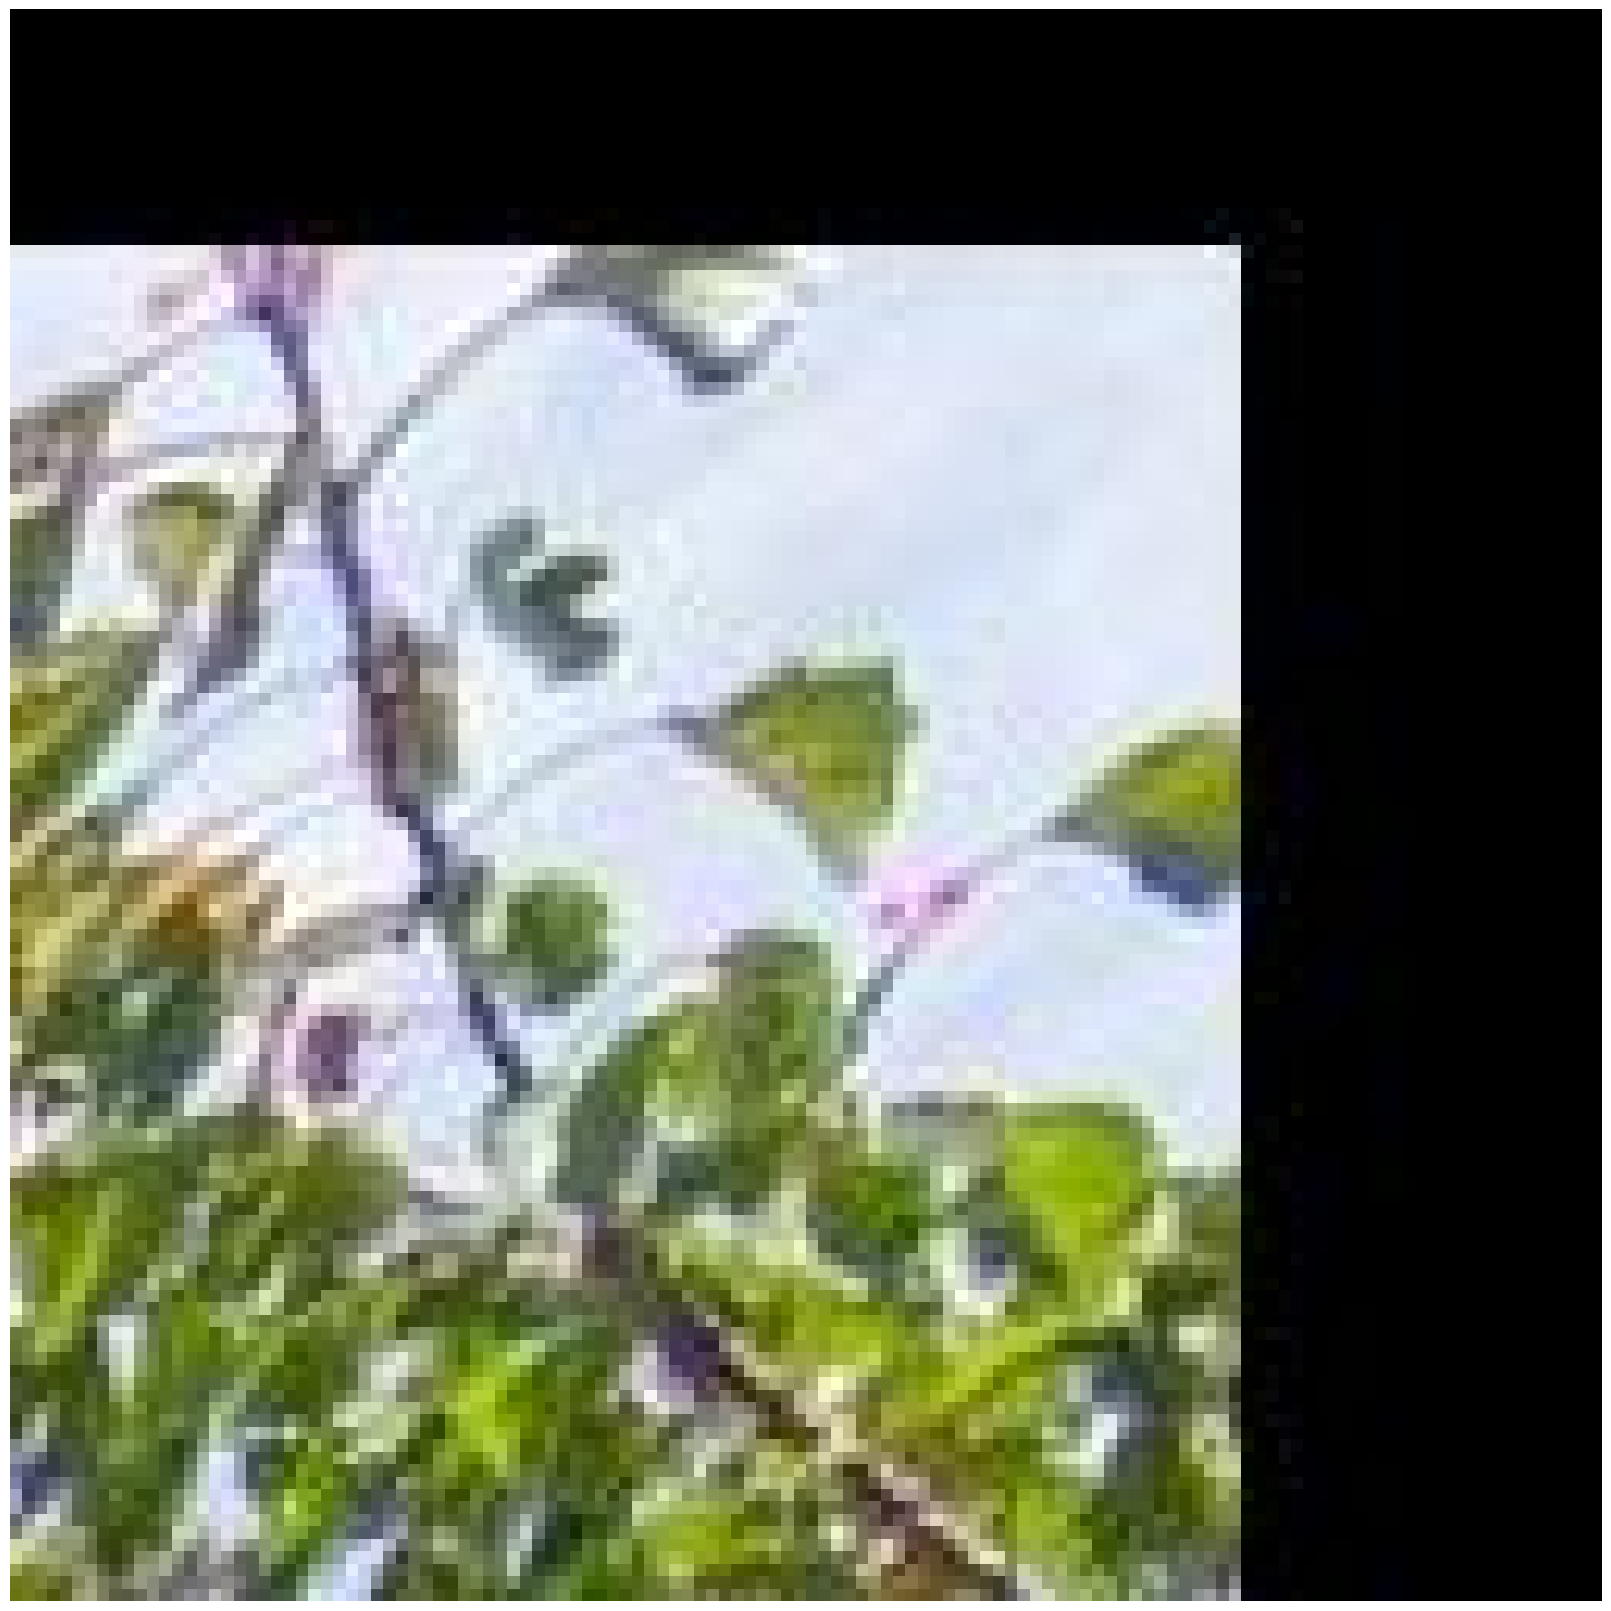

1


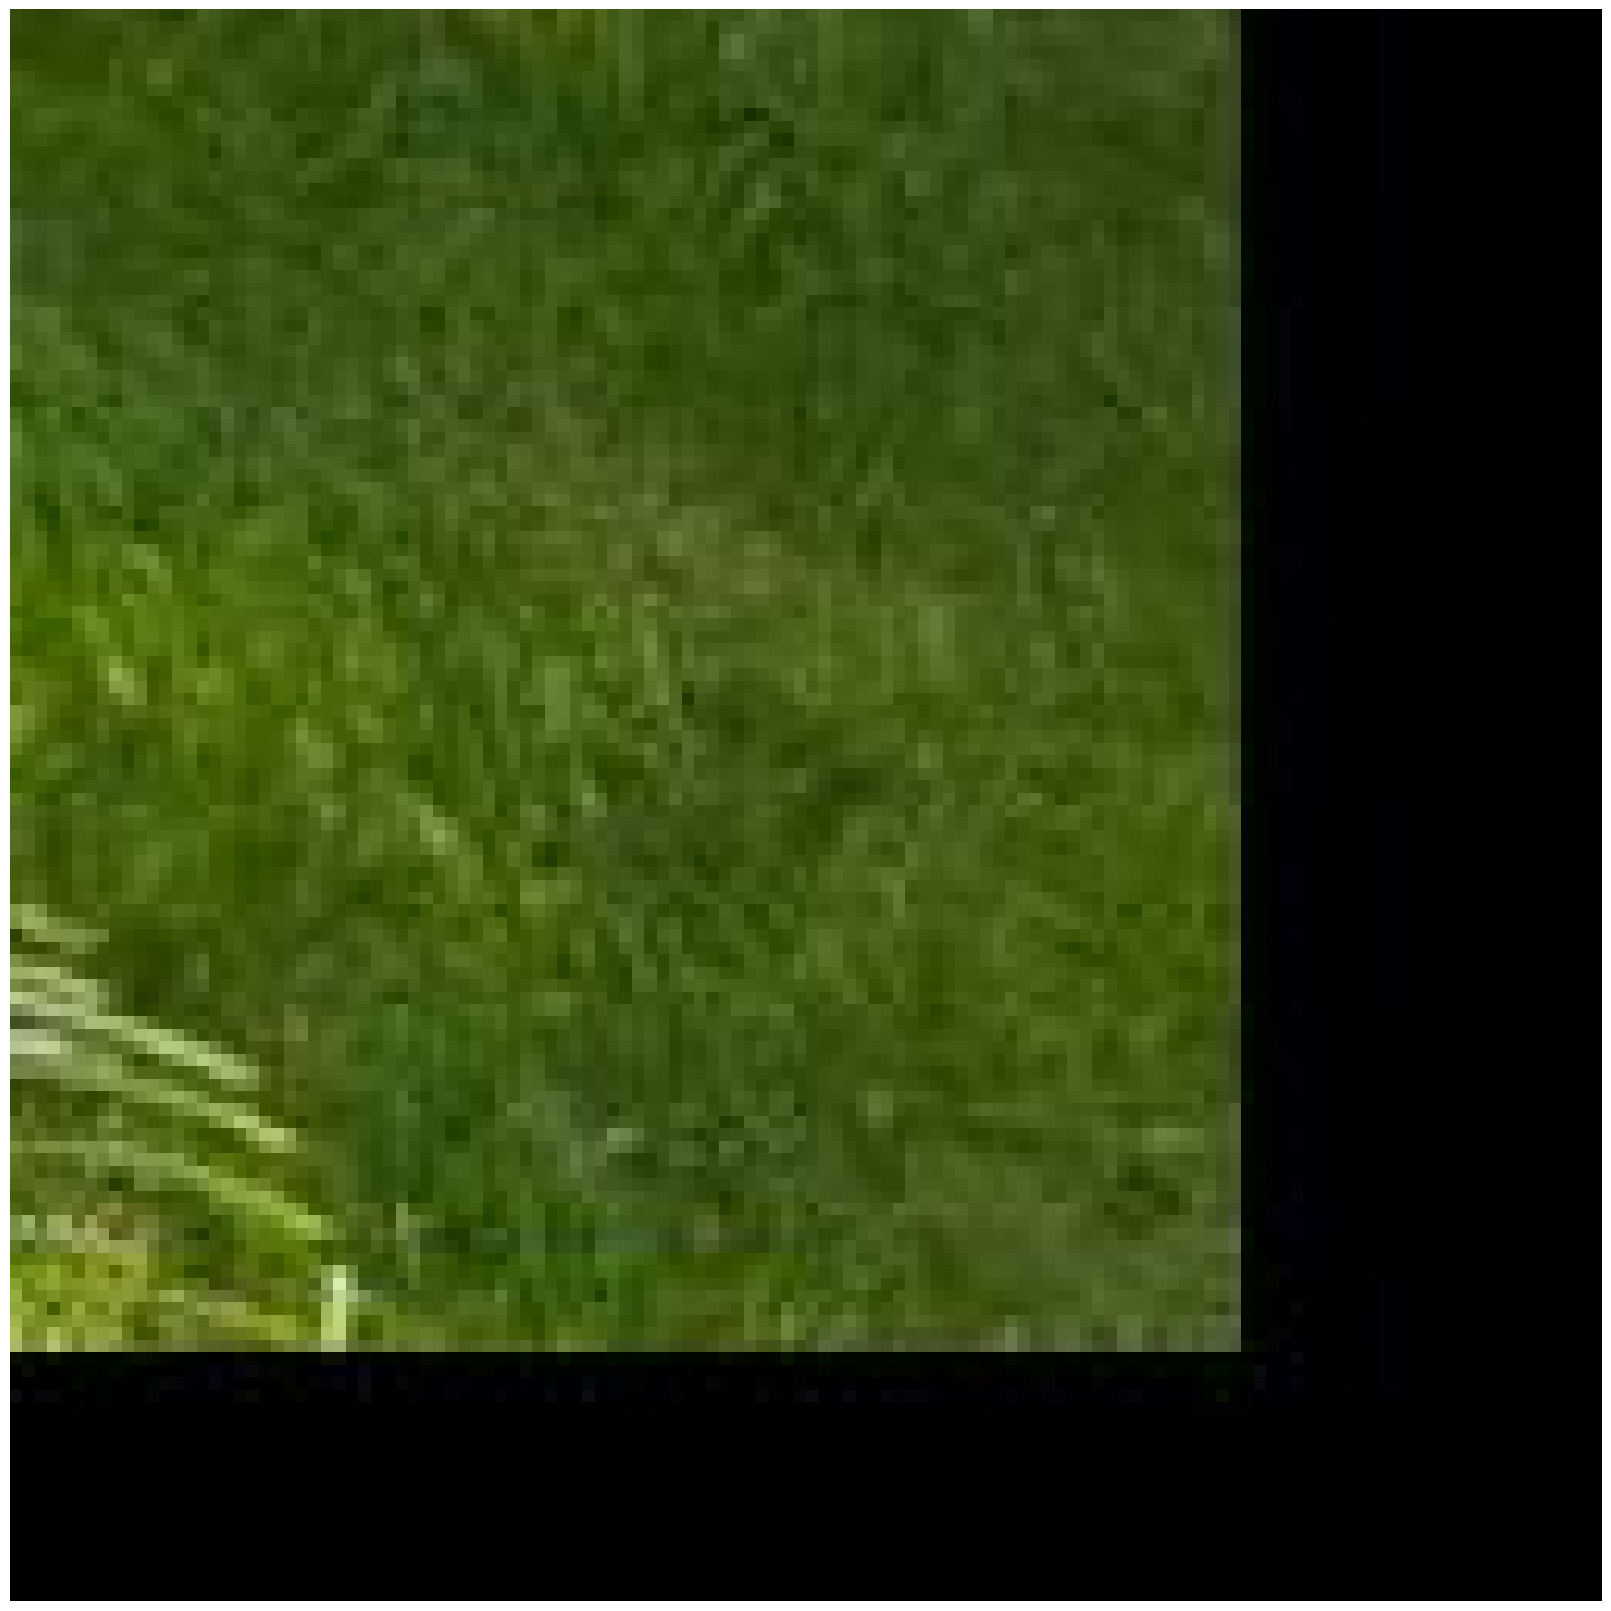

In [69]:
pos_pieces = puzzle(pieces)

In [18]:
def get_puzzle(name_puzzle):
    path = "./puzzle/"+name_puzzle+'/'
    names = os.listdir(path)
    puzzle = []
    for path_im in os.listdir(path):
        puzzle.append(cv2.imread(path+'/'+path_im))
        puzzle[-1] = cv2.cvtColor(puzzle[-1], cv2.COLOR_BGR2RGB)
    return puzzle

In [19]:
pieces = get_puzzle('su_fighter_shuffle')
res_im = cv2.imread("./puzzle/su_fighter.jpg")
res_im = cv2.cvtColor(res_im, cv2.COLOR_BGR2RGB)

In [20]:
pieces = get_puzzle('china_shuffle')
res_im = cv2.imread("./puzzle/china.jpg")
res_im = cv2.cvtColor(res_im, cv2.COLOR_BGR2RGB)

In [21]:
pieces = get_puzzle('home_shuffle')
res_im = cv2.imread("./puzzle/home.jpg")
res_im = cv2.cvtColor(res_im, cv2.COLOR_BGR2RGB)

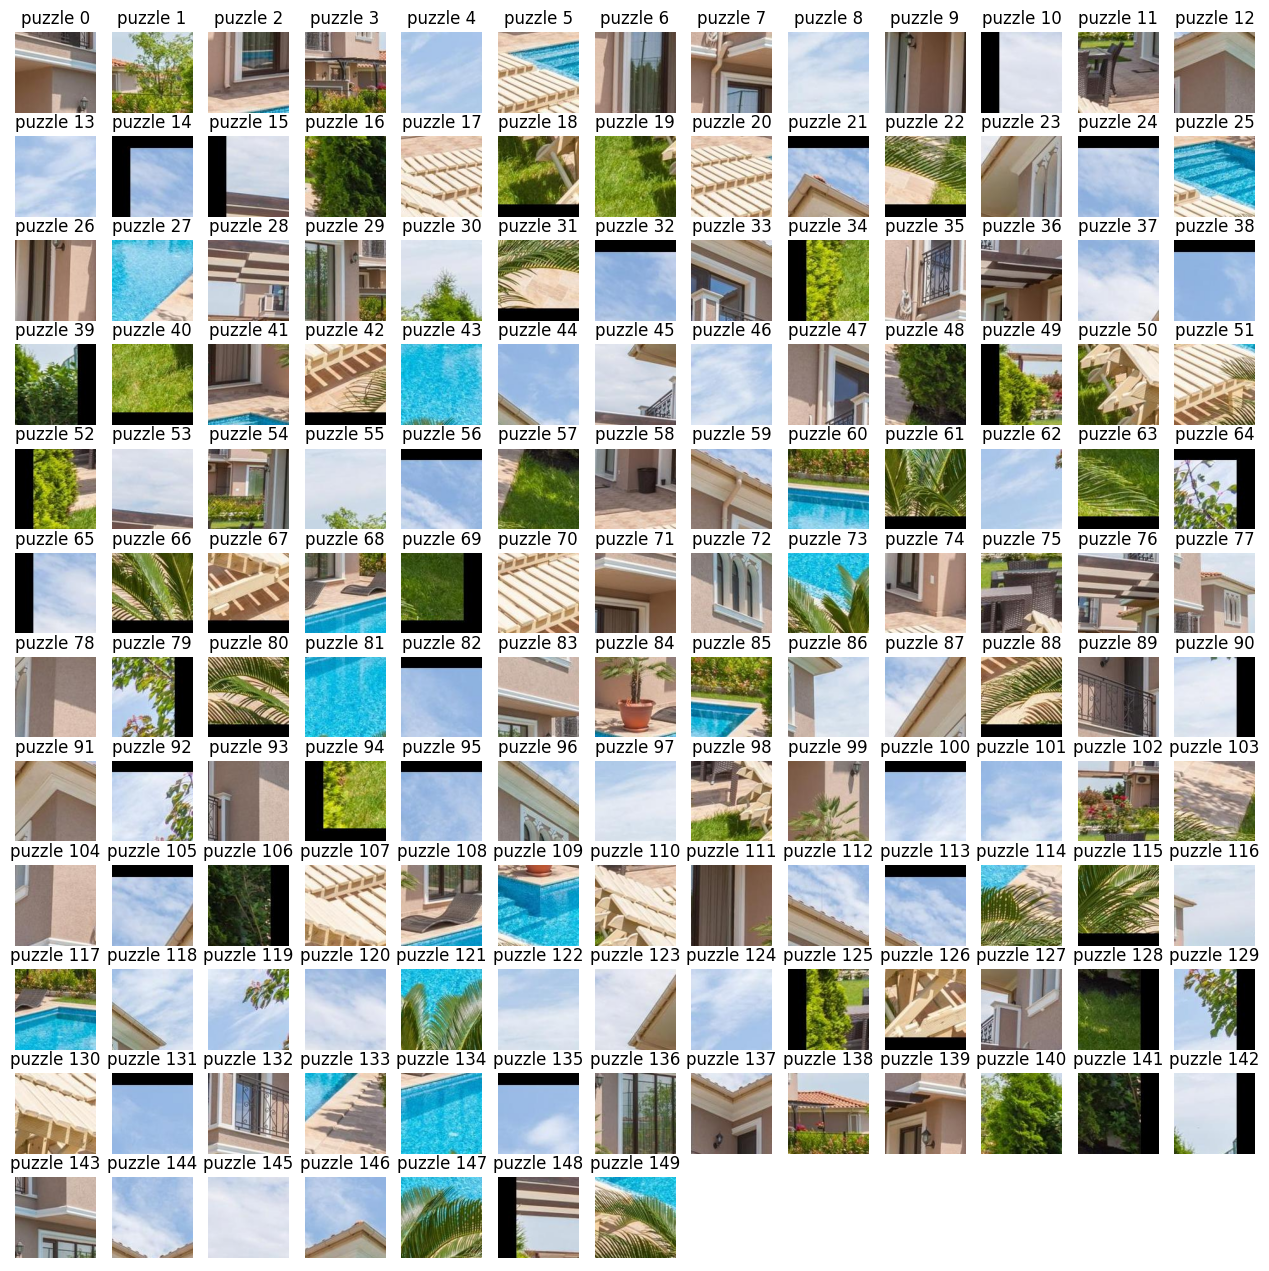

In [22]:
a = int(np.sqrt(len(pieces)))+1
fig, axes = plt.subplots(len(pieces)//a+1, a, figsize=(16, 16))
axes = axes.ravel()

for i in range(len(pieces)):
    axes[i].imshow(pieces[i])
    axes[i].set_title(f'puzzle {i}')
    
for ax in axes:
    ax.axis('off')

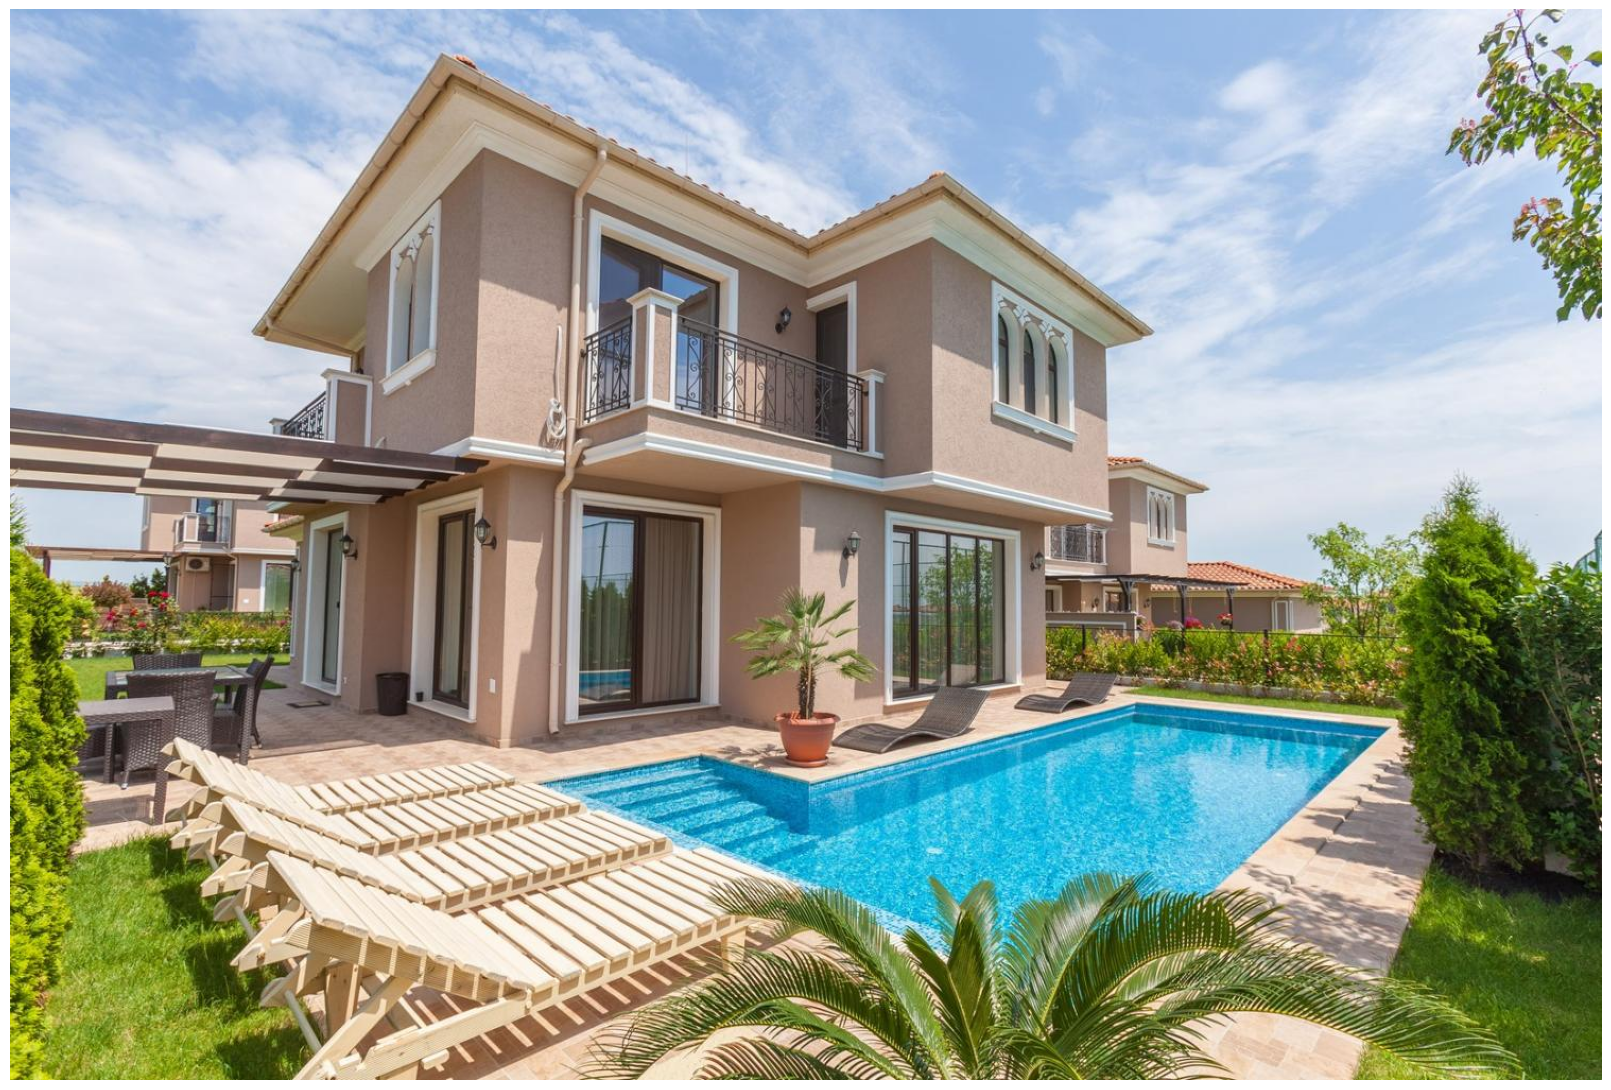

In [23]:
plot_one_image(res_im)